# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline


# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.legend import Legend
import pandas as pd
from IPython.display import display, HTML, Markdown
from scipy.sparse import csr
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

# SK-learn libraries for learning.
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from sklearn.pipeline import Pipeline

# Display centered pandas tables
def pd_centered(df):
    return df.style.set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}])
# Print in bold
def printmd(string):
    display(Markdown(string))

# Plot formats
from cycler import cycler
import matplotlib.patches as patches
import matplotlib.mlab as mlab
import matplotlib.dates
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.color'] = 'blue'
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#30a2da', '#e5ae38', '#fc4f30', '#6d904f', '#8b8b8b'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.facecolor'] = '#f0f0f0'
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['axes.labelpad'] = 0.0
mpl.rcParams['axes.xmargin'] = 0.05  # x margin.  See `axes.Axes.margins`
mpl.rcParams['axes.ymargin'] = 0.05  # y margin See `axes.Axes.margins`
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['figure.subplot.left'] = 0.08
mpl.rcParams['figure.subplot.right'] = 0.95
mpl.rcParams['figure.subplot.bottom'] = 0.07

# figure configuration
fsize = (10,7.5) # figure size
tsize = 18 # title font size
lsize = 16 # legend font size
csize = 14 # comment font size
grid = True # grid

# Set the randomizer seed so results are the same each time ... Reproducibility
np.random.seed(0)

Load feature names.

In [2]:
feature_names = []
with open("./Data/mushroom.map") as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print('Loaded feature names:', len(feature_names))

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [3]:
X, Y = [], []

with open('./Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


## (1) 
Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

### PCA on train data

Absolute variance of each principal component of the train data


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125
Variance of PC,0.0886,0.0791,0.0713,0.0596,0.0526,0.0452,0.0415,0.0268,0.0238,0.0228,0.0194,0.0185,0.0181,0.0158,0.0142,0.0137,0.0119,0.0116,0.0115,0.011,0.0109,0.0098,0.0098,0.0096,0.0094,0.0093,0.0093,0.0092,0.0091,0.009,0.0088,0.0087,0.0087,0.0085,0.0084,0.0083,0.0083,0.008,0.0079,0.0076,0.0076,0.0074,0.0071,0.0071,0.0069,0.0068,0.0067,0.0064,0.0062,0.0061,0.006,0.0058,0.0056,0.0054,0.0052,0.0051,0.0046,0.0044,0.0043,0.0041,0.004,0.0038,0.0035,0.0034,0.0032,0.003,0.003,0.0028,0.0027,0.0025,0.0022,0.0021,0.0018,0.0015,0.0015,0.0012,0.0008,0.0006,0.0005,0.0004,0.0003,0.0002,0.0002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Total principal components:  126


### Cumulative variance of first 50 components

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
Variance of PC,0.0886,0.1678,0.2391,0.2986,0.3513,0.3965,0.4379,0.4647,0.4885,0.5113,0.5307,0.5492,0.5673,0.5831,0.5973,0.611,0.6228,0.6344,0.6459,0.657,0.6679,0.6777,0.6875,0.6971,0.7065,0.7159,0.7252,0.7344,0.7435,0.7525,0.7614,0.7701,0.7788,0.7873,0.7957,0.8041,0.8124,0.8204,0.8283,0.8359,0.8435,0.8509,0.858,0.8652,0.8721,0.8789,0.8856,0.892,0.8982,0.9043


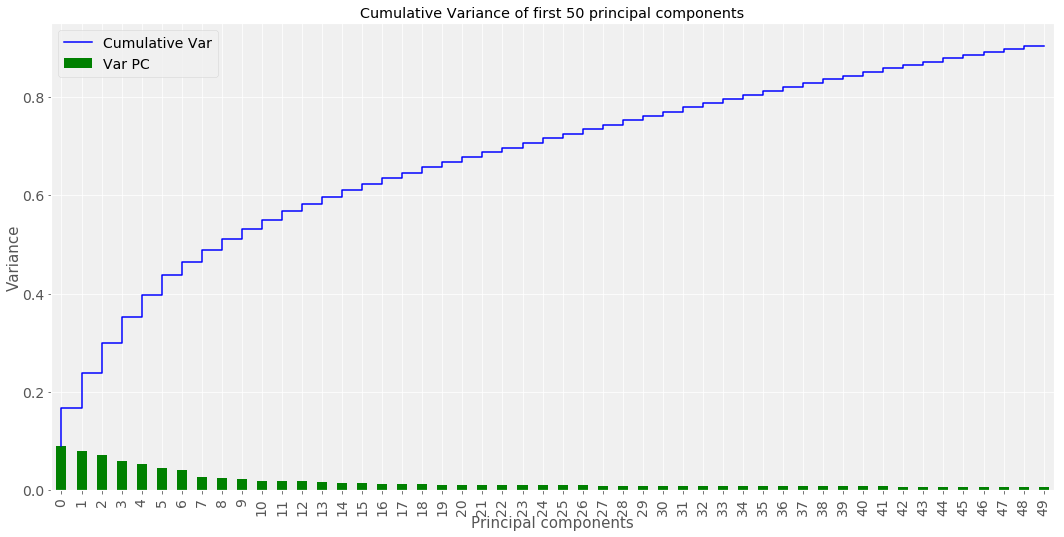

In [4]:
def P1():
    """ 
    1st Problem. Run PCA on the data, and show fraction of variance explain for the first k components
    Let's remember to first normalize the data before running PCA
    Args:
        No arguments. All data is loaded in the global environment
    Returns:
        The function will return a report with two outputs: 
            1.- The total variance of the first 50 principal components in the form of a dataframe, on the train data
            2.- The total variance accumulated for the first 50 principal components in the form of a graph
    """
    # Run a PCA on the data. In terms of parameters, we want all components to be kept for our variance analysis
    normalizer = StandardScaler()
    normalizer.fit(train_data)
    norm_train_data = normalizer.transform(train_data)
    
    pca = PCA()
    pca.fit(norm_train_data)
    var_pc = pd.DataFrame(pca.explained_variance_ratio_, columns = ['Variance of PC']).T
    printmd('### PCA on train data')
    print('Absolute variance of each principal component of the train data')
    display(pd_centered(var_pc.round(4)))
    print("Total principal components: ", var_pc.shape[1])
    
    # Graph total cumulative variance per principal component, for the first 50 components
    var_50pc = var_pc.T[0:50].T
    var_50pc_cum = var_pc.T[0:50].cumsum().T
    printmd('### Cumulative variance of first 50 components')
    display(pd_centered(var_50pc_cum.round(4)))
    fig, ax = plt.subplots(figsize=(16,8))
    var_50pc_cum.T.plot(drawstyle='steps', linestyle='-', color = 'b', label = 'Cumulative Var', ax=ax)
    var_50pc.T.plot.bar(color='g', ax=ax)
    ax.set_title("Cumulative Variance of first 50 principal components")
    ax.set_xlabel('Principal components')
    ax.set_ylabel('Variance')
    ax.legend(['Cumulative Var', 'Var PC'])
    plt.show()
    
P1()

## Answer

Using normalized data (for all the assignment), we can check that the first components explain almost 80% of the variance of the entire set of features. Half of the information is contained in the first 10 components

## (2) 
PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

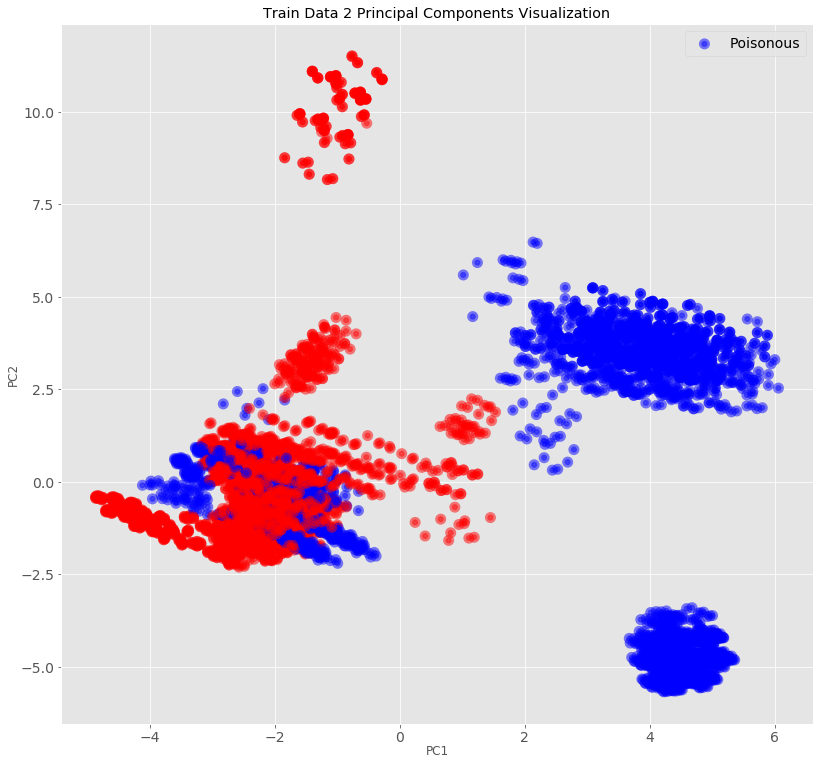

In [5]:
def P2():
    """ 
    2nd Problem. Run PCA on the data and extract 2 dimensions to plot it
    Args:
        No arguments. All data is loaded in the global environment
    Returns:
        The function will return a visualization of data, with a color code 
    """ 
    # Run PCA
    normalizer = StandardScaler()
    normalizer.fit(train_data)
    norm_train_data = normalizer.transform(train_data)
    
    pca_2pc = PCA(n_components=2)
    pca_2pc.fit(norm_train_data)
    train_pca = pca_2pc.transform(norm_train_data)
    
    # Plot the points using blue and red as a reference
    plt.style.use('ggplot')
    mpl.rcParams['figure.figsize'] = [12,12]
    fig, ax = plt.subplots()
    color = ['b' if i == 1 else 'r' for i in train_labels]
    ax.scatter(train_pca[:,0],train_pca[:,1], linewidths=5, alpha=.5, marker='o', c=color)
    ax.set_title("Train Data 2 Principal Components Visualization")
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.legend((['Poisonous']))
    plt.show()
    
P2()

## (3) 
Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

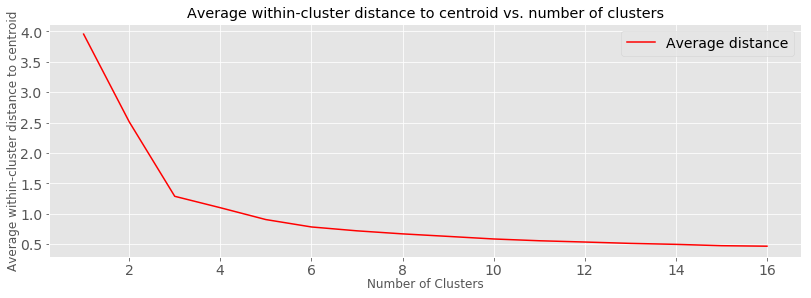

### From the elbow analyis, we visualize k=3 and k=6

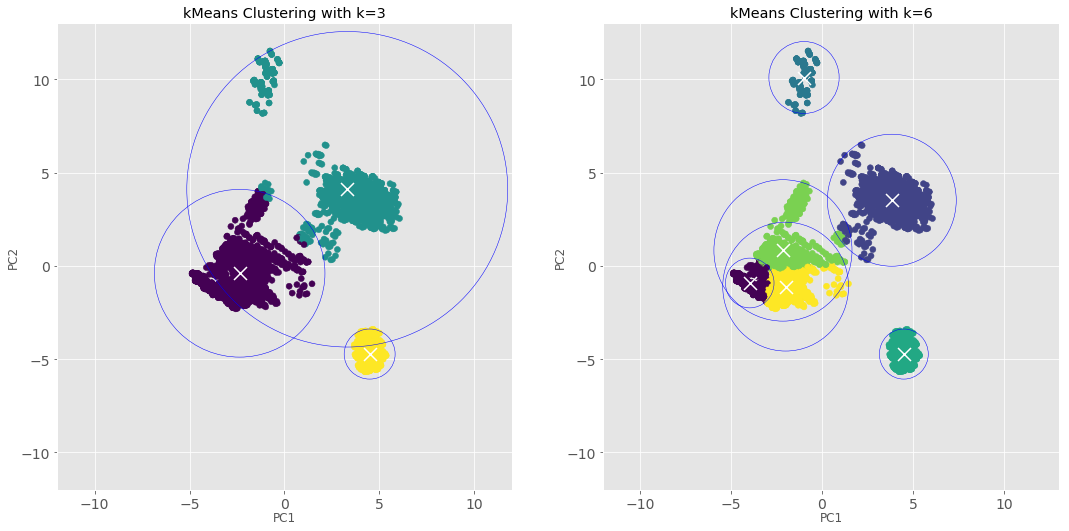

In [6]:
def P3():
    """ 
    3rd Problem. Run a KMeans model with K running from 1 to 16, choose the better one in terms of loss, and plot it
    Args:
        No arguments. All data is loaded in the global environment
    Returns:
        The function will return a report with two visualizations: 
            a.- Average within-Cluster distance to Centroid vs. number of K
            b.- Clustering of the data once we have the best k
    """ 
    # Run PCA
    normalizer = StandardScaler()
    normalizer.fit(train_data)
    norm_train_data = normalizer.transform(train_data)
    
    pca_2pc = PCA(n_components=2)
    pca_2pc.fit(norm_train_data)
    train_pca = pca_2pc.transform(norm_train_data)
    
    # Run KMeans from k=2 to k=16, plot the average within cluster distance and choose the best one
    k_means = [i+1 for i in range(16)]
    dist = []
    for k in k_means:
        kMeans = KMeans(n_clusters = k, n_jobs=-1)
        kMeans.fit(train_pca)
        dist.append(sum(np.min(cdist(train_pca,kMeans.cluster_centers_,'euclidean'),axis=1))/train_pca.shape[0])
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(k_means, dist, linestyle='-', color = 'r')
    ax.set_title("Average within-cluster distance to centroid vs. number of clusters")
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel('Average within-cluster distance to centroid')
    ax.legend(['Average distance'])   
    plt.show()
    
    # From elbow analysis, best Ks are k=3 and k=6, we use them for cluster visualization
    printmd('### From the elbow analyis, we visualize k=3 and k=6')
    kMeans_3 = KMeans(n_clusters = 3, n_jobs=-1)
    kMeans_3.fit(train_pca)
    centroids_3 = kMeans_3.cluster_centers_
    label_3 = kMeans_3.predict(train_pca)
    distances_3 = kMeans_3.transform(train_pca)
    max_3 = []
    for i in range(3):
        max_3.append(np.max(distances_3[label_3==i][:,i]))
    
    kMeans_6 = KMeans(n_clusters = 6, n_jobs=-1)
    kMeans_6.fit(train_pca)
    centroids_6 = kMeans_6.cluster_centers_
    label_6 = kMeans_6.predict(train_pca)
    distances_6 = kMeans_6.transform(train_pca)
    max_6 = []
    for i in range(6):
        max_6.append(np.max(distances_6[label_6==i][:,i]))

    
    # Plot kMeans with k = 3
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(1,2,1)
    ax.scatter(train_pca[:,0], train_pca[:,1], c=label_3)
    ax.scatter(centroids_3[:,0], centroids_3[:,1], marker = 'x', s=169, linewidths=3, color='w')
    ax.set_title('kMeans Clustering with k=3')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_xlim(-12,12)
    ax.set_ylim(-12,13)
    for i in range(3):
        circle = plt.Circle((centroids_3[i,0], centroids_3[i,1]), radius=max_3[i], fill=False, color='b')
        ax.add_patch(circle)
    
    # Plot kMeans with k = 6
    ax = fig.add_subplot(1,2,2)
    ax.scatter(train_pca[:,0], train_pca[:,1], c=label_6)
    ax.scatter(centroids_6[:,0], centroids_6[:,1], marker = 'x', s=169, linewidths=3, color='w')
    ax.set_title('kMeans Clustering with k=6')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_xlim(-12,13)
    ax.set_ylim(-12,13)
    for i in range(6):
        circle = plt.Circle((centroids_6[i,0],centroids_6[i,1]), radius=max_6[i], fill=False, color='b')
        ax.add_patch(circle)
    

P3()

## Answer

To decide which of all the possible kMeans to visualize, I decided to do an elbow analisis: Which model have the biggest change in slope in terms of average within-cluster distance to centroid, a metric of distortion. Obviously, the higher the number of K, the smallest the average distortion will be, but we want the k that produces the biggest 'jump' in the change of slope. From our analysis, the best jumps are **k=3** and **k=6**

## (4) 
Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

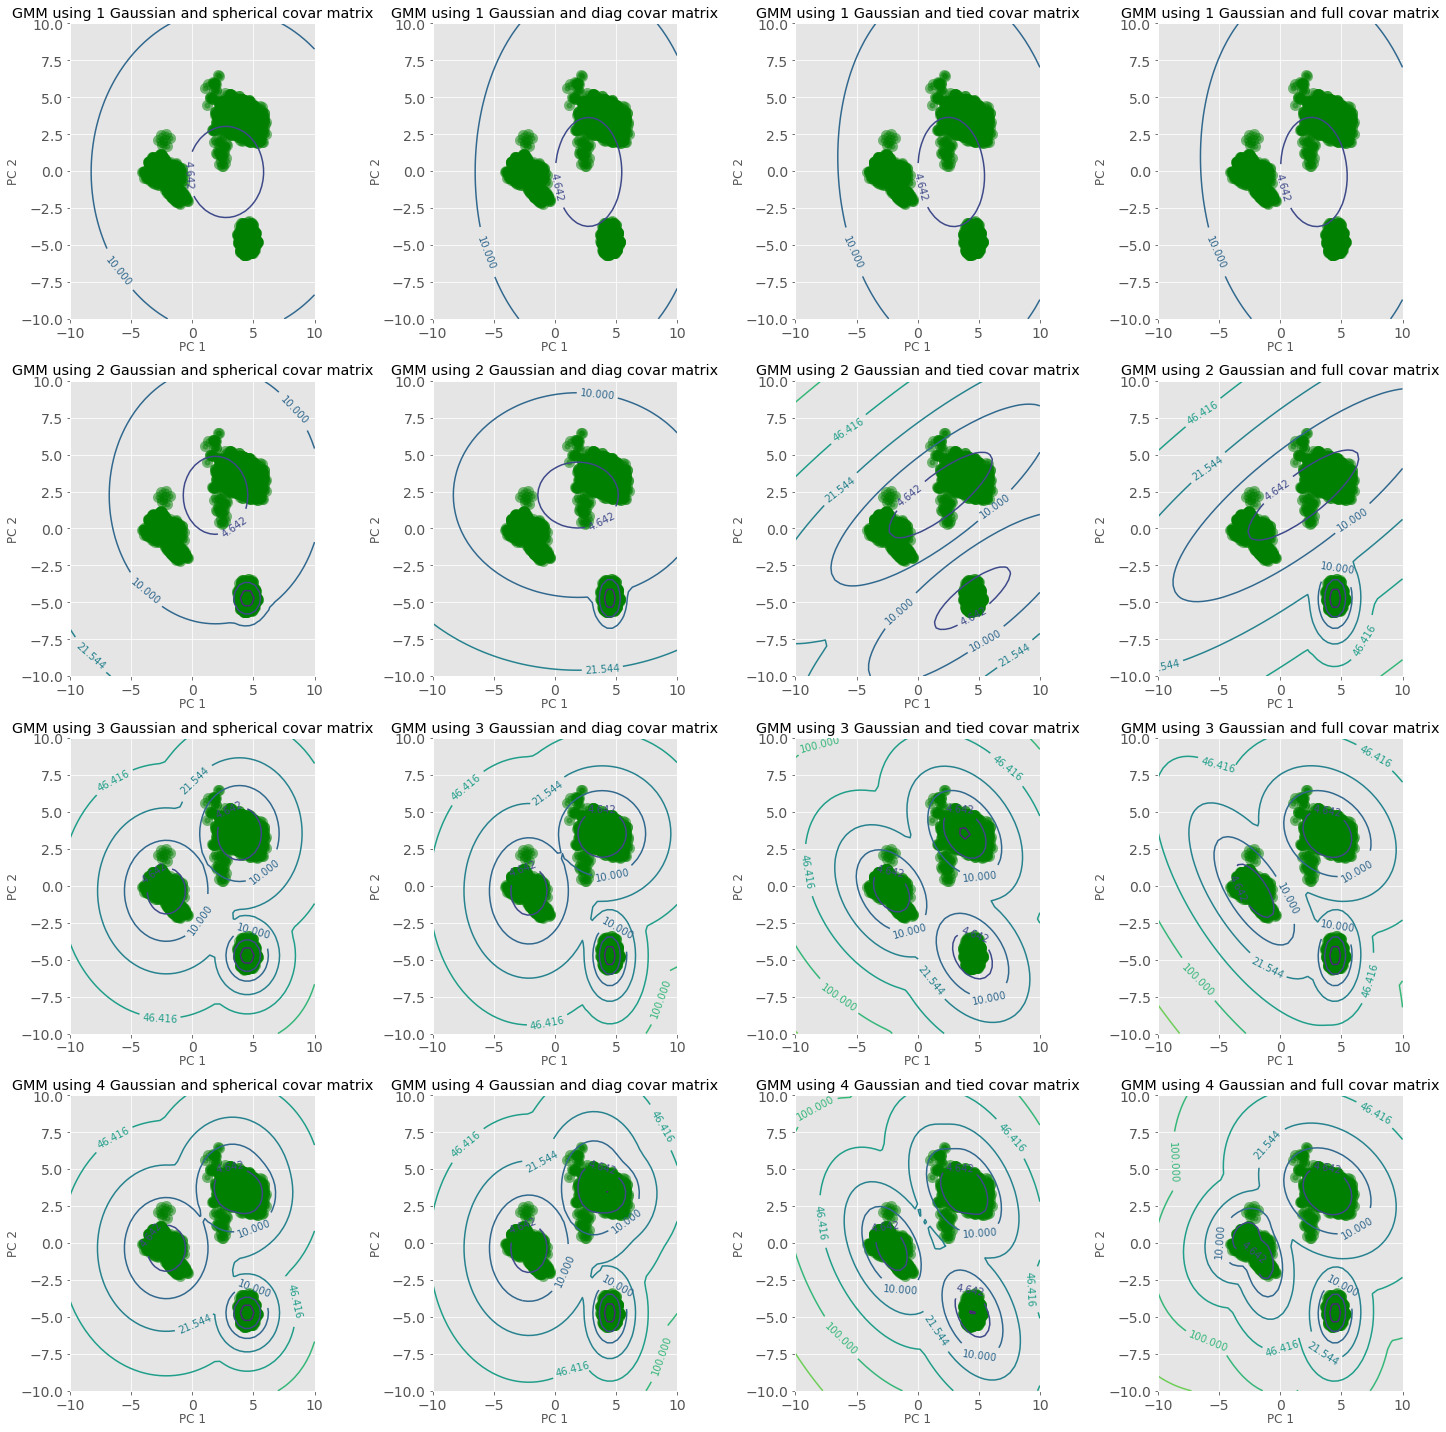

In [7]:
def P4():
    """ 
    4th Problem. Run a GMM model on the 2 PC of the positive examples of the data
    Args:
        No arguments. All data is loaded in the global environment
    Returns:
        The function will return a visualization of the clustering of the data, going from 1 Gaussian to 4
    """ 
    # Run the PCA
    normalizer = StandardScaler()
    normalizer.fit(train_data)
    norm_train_data = normalizer.transform(train_data)
    
    pca_2pc = PCA(n_components=2)
    pca_2pc.fit(norm_train_data)
    train_pca = pca_2pc.transform(norm_train_data)
    
    
    # Plot the clustering using 1 through 4 Mixture components and varying covariance matrix type
    n_comp = [1,2,3,4]
    cov_type = ['spherical','diag','tied', 'full']
    plt.style.use('ggplot')
    mpl.rcParams['figure.figsize'] = [20,20]   
    fig,ax = plt.subplots(4,4,figsize=(20,20))
    for i in n_comp:
        k = 0
        for j in cov_type:
            GMM = GaussianMixture(n_components=i, covariance_type=j)
            GMM.fit(train_pca[train_labels==1])
            x = np.linspace(-10,10)
            y = np.linspace(-10,10)
            X, Y = np.meshgrid(x,y)
            XX = np.array([X.ravel(),Y.ravel()]).T
            Z = -GMM.score_samples(XX)
            Z = Z.reshape(X.shape)
            CS = ax[i-1,k].contour(X,Y,Z, norm=LogNorm(vmin=1.0, vmax=1000.0),levels=np.logspace(0,3,10))
            CB = ax[i-1,k].clabel(CS, shrink=0.8, extend='both')
            ax[i-1,k].scatter(train_pca[:,0][train_labels==1],\
                              train_pca[:,1][train_labels==1],linewidths=5, alpha=.5, marker='o', color = 'g')
            ax[i-1,k].set_title('GMM using %d Gaussian and %s covar matrix'%(i,j))
            ax[i-1,k].set_xlabel('PC 1')
            ax[i-1,k].set_ylabel('PC 2')
            k += 1
    fig.tight_layout()
            
P4()

## (5) 
Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [8]:
def P5():
    """ 
    5th Problem. Run a 4-component full covariance GMM on positive and negative data. Report accuracy on test set
    Args:
        No arguments. All data is loaded in the global environment
    Returns:
        The function will return a report of the accuracy of the model on the test set
    """ 
    # For reproducibility, let's set the random seed to 0
    np.random.seed(0)
    
    # Fit GMM on positive examples and negative examples
    normalizer = StandardScaler()
    normalizer.fit(train_data)
    norm_train_data = normalizer.transform(train_data)
    
    pca_2pc = PCA(n_components=2)
    pca_2pc.fit(norm_train_data)
    train_pca = pca_2pc.transform(norm_train_data)
    
    gmm_pos = GaussianMixture(n_components=4, covariance_type='full')
    gmm_pos.fit(train_pca[train_labels==1])
    gmm_neg = GaussianMixture(n_components=4, covariance_type='full')
    gmm_neg.fit(train_pca[train_labels==0])
    
    # Set a label for each train point
    normalizer.fit(test_data)
    norm_test_data = normalizer.transform(test_data)    
    
    test_pca = pca_2pc.transform(norm_test_data)
    prob_test_pos = np.exp(gmm_pos.score_samples(test_pca))
    prob_test_neg = np.exp(gmm_neg.score_samples(test_pca))
    
    predict_label = np.where(prob_test_pos>prob_test_neg,1,0)
    accuracy = metrics.accuracy_score(test_labels, predict_label)
    printmd('### Accuracy of two 4-component full covariance GMM on positive and negative data')
    printmd('Accuracy of the model is %.04f'%accuracy)
    
P5()

### Accuracy of two 4-component full covariance GMM on positive and negative data

Accuracy of the model is 0.8639

## (6) 
Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

### Best configuration

The best configuration is with **10** PCA components, **2** GMM dimensions, and a **spherical** covariance type

The best accuracy on the test set is *0.9591*

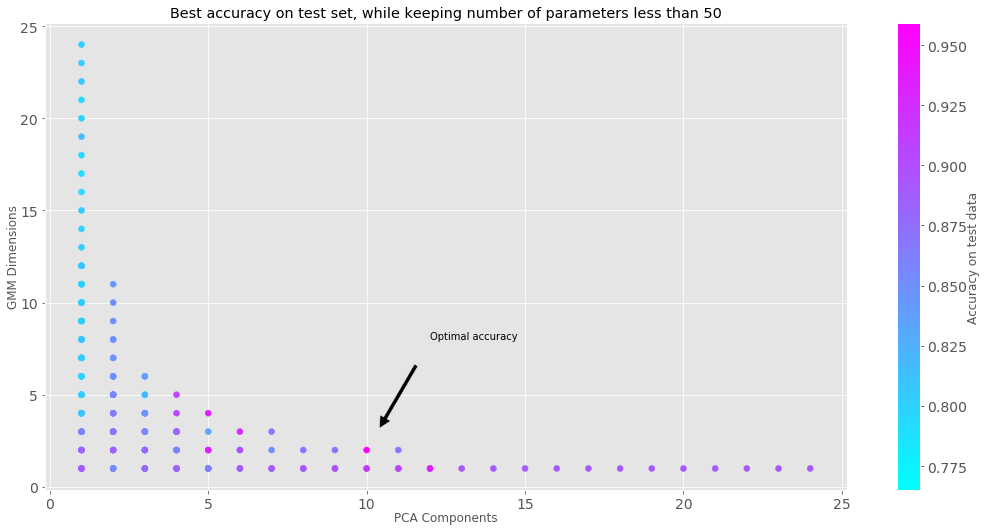

In [9]:
def number_par(pca_comp, gmm_dim, gmm_cov_type):
    """ 
    Count the number of parameters between the PCA and the GMM model
    Args:
        pca_comp: The number of principal components that we'll run
        gmm_dim: The dimension of the GMM model
        gmm_cov_type: The type of the covariance matrix: comes from list ['spherical','diag','tied', 'full']
    Returns:
        Total number of parameters
    """
    # The number of parameters will be multiply by 2 because we have 2 classes: positive + negative
    dic_par = {'spherical': gmm_dim*1,\
               'diag': gmm_dim*pca_comp,\
               'tied': 1*((pca_comp**2-pca_comp)/2+pca_comp),\
               'full': gmm_dim*((pca_comp**2-pca_comp)/2+pca_comp)}
    par = 2*(pca_comp*gmm_dim+dic_par[gmm_cov_type])
    return int(par)

def get_accuracy(pca_comp, gmm_dim, gmm_cov_type):
    """ 
    Run the training and testing separate from the loop that collects the accuracies
    Args:
        pca_comp: The number of principal components that we'll run
        gmm_dim: The dimension of the GMM model
        gmm_cov_type: The type of the covariance matrix: comes from list ['spherical','diag','tied', 'full']
    Returns:
        Outputs the accuracy of the model on the train set
    """
    # For reproducibility, let's set the random seed to 0
    np.random.seed(0)
    
    # Fit GMM on positive examples and negative examples
    normalizer = StandardScaler()
    normalizer.fit(train_data)
    norm_train_data = normalizer.transform(train_data)
    
    pca_2pc = PCA(n_components=pca_comp)
    pca_2pc.fit(norm_train_data)
    train_pca = pca_2pc.transform(norm_train_data)
    
    gmm_pos = GaussianMixture(n_components=gmm_dim, covariance_type=gmm_cov_type)
    gmm_pos.fit(train_pca[train_labels==1])
    gmm_neg = GaussianMixture(n_components=gmm_dim, covariance_type=gmm_cov_type)
    gmm_neg.fit(train_pca[train_labels==0])
    
    # Set a label for each train point
    normalizer.fit(test_data)
    norm_test_data = normalizer.transform(test_data)    
    
    test_pca = pca_2pc.transform(norm_test_data)
    prob_test_pos = np.exp(gmm_pos.score_samples(test_pca))
    prob_test_neg = np.exp(gmm_neg.score_samples(test_pca))
    
    predict_label = np.where(prob_test_pos>prob_test_neg,1,0)
    accuracy = metrics.accuracy_score(test_labels, predict_label)
    return [accuracy, pca_comp, gmm_dim, gmm_cov_type]

def P6():
    """ 
    6th Problem. Find the best accuracy while keeping the number of parameters small (less than 50)
    Args:
        No arguments. All data is loaded in the global environment
    Returns:
        The function will report the accuracies for each combinination of PCA and GMM models
    """ 
    # Run the model for several combinations of PCA, GMM dimensions and covariance matrix
    cov_type = ['spherical','diag','tied', 'full']
    pca_comp = [i+1 for i in range(50)]
    gmm_dim = [i+1 for i in range(50)]
    acc = []
    for cov in cov_type:
        for i in pca_comp:
            for j in gmm_dim:
                num_par = number_par(i, j, cov)
                if num_par > 50:
                    break
                acc.append(get_accuracy(i, j, cov))
    values = np.array([row[:3]+row[4:] for row in acc])
    
    # Visualization
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(1,1,1)
    index = np.argmax(values[:,0])
    cmap = mpl.cm.cool
    norm = mpl.colors.Normalize(vmin=np.min(values[:,0]), vmax=np.max(values[:,0]))
    colors = [cmap(norm(value)) for value in values[:,0]]
    ax.scatter(values[:,1],values[:,2], color=colors)
    ax.set_title('Best accuracy on test set, while keeping number of parameters less than 50')
    ax.set_xlabel('PCA Components')
    ax.set_ylabel('GMM Dimensions')  
    ax.annotate('Optimal accuracy', xy=(values[index,1], values[index,2]), xytext = (12,8),
               arrowprops=dict(facecolor='black', shrink=0.2),)
    cax, _ = mpl.colorbar.make_axes(ax)
    cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
    cb.set_label('Accuracy on test data')
    
    best = acc[index]
    printmd('### Best configuration')
    printmd('The best configuration is with **%d** PCA components, **%d** GMM dimensions, and a **%s** covariance type'\
           %(best[1], best[2], best[3]))
    printmd('The best accuracy on the test set is *%0.4f*'%best[0])
    
P6()